In [12]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import sys
import numpy as np
sys.path.append('/Users/wastechs/Documents/git-repos/energy-efficiency')
from lib.util.helper import query_table, weekday_time_series
import seaborn as sns
import plotly.express as px
#import statsmodels.api as sm

In [22]:
druck_5T = query_table(table='r707lv_f4032_1T')
trock_5T = query_table(table='r707lv_trockner_5T')
puder_5T = query_table(table='r707lv_f4034_5T')
vari_5T = query_table(table='r707lv_vari_air_5T')

In [23]:
px.line(
    x=druck_5T.index, y=druck_5T.kw, 
    title='R707LV - Druckmaschine',
    labels={
        'x': 'Time',
        'y': 'Watts'
    })

In [15]:
px.line(
    x=trock_5T.index, y=np.log(trock_5T.kw), 
    title='R707LV - Trockner Maschine',
    labels={
        'x': 'Time',
        'y': 'kW'
    })

In [16]:
px.line(
    x=puder_5T.index, y=puder_5T.kw, 
    title='R707LV - Puderabsaugung Maschine',
    labels={
        'x': 'Time',
        'y': 'kW'
    })

In [17]:
px.line(
    x=vari_5T.index, y=vari_5T.kw, 
    title='R707LV - Vari Air',
    labels={
        'x': 'Time',
        'y': 'kW'
    })

### Cross Correlation of Components in R707LV 

In [18]:
def cross_correlation(feat1, feat2):
    cross_corr = sm.tsa.stattools.ccf(feat1, feat2, adjusted=False)
    return cross_corr

In [19]:
cc_1 = cross_correlation(vari_5T.p, puder_5T.p)
cc_2 = cross_correlation(vari_5T.p, trock_5T.p)
cc_3 = cross_correlation(vari_5T.p, druck_5T.p)

cc_4 = cross_correlation(puder_5T.p, druck_5T.p)
cc_5 = cross_correlation(puder_5T.p, trock_5T.p)
cc_8 = cross_correlation(trock_5T.p, druck_5T.p)

NameError: name 'sm' is not defined

In [ ]:
def plot_autocorr(x, axis=None, plot_marker=True):

    if not axis:
        _, axis = plt.subplots(figsize=(20, 7))

    if plot_marker:
        axis.plot(x, 'o')

    axis.vlines(range(len(x)), [0], x)
    axis.axhline()

    return axis

In [ ]:
plot_autocorr(cc_1, plot_marker=True) 
plt.title('Vari Air & Puder.')
plt.show()

In [ ]:
plot_autocorr(cc_2, plot_marker=True)
plt.title('Vari Air & Trock.') 
plt.show()

In [ ]:
plot_autocorr(cc_3, plot_marker=True) 
plt.title('Vari Air & Druck.')
plt.show()

In [ ]:
plot_autocorr(cc_4, plot_marker=True) 
plt.title('Puder. & Druck.')
plt.show()

In [ ]:
plot_autocorr(cc_5, plot_marker=True) 
plt.title('Puder. & Trock.')
plt.show()

In [ ]:
plot_autocorr(cc_8, plot_marker=True) 
plt.title('Trock. & Druck.')
plt.show()

### Correlation Coefficient of Components in R707LV

In [ ]:
puder_5T.p.values

In [ ]:
r707lv_dict = {
    'pudermaschine': puder_5T.p.values,
    'trockner': trock_5T.p.values,
    'vari_air': vari_5T.p.values,
    'druckmaschine': druck_5T.p.values
    }

In [ ]:
r707lv__log_dict = {
    'pudermaschine': np.log(puder_5T.p.values) - np.log(puder_5T.p.shift(1)),
    'trockner': np.log(trock_5T.p.values) - np.log(trock_5T.p.shift(1)),
    'vari_air': np.log(vari_5T.p.values) - np.log(vari_5T.p.shift(1)),
    'druckmaschine': np.log(druck_5T.p.values) - np.log(druck_5T.p.shift(1))
    }

In [ ]:
r707lv = pd.DataFrame.from_dict(
    data=r707lv_dict)

r707lv_log = pd.DataFrame.from_dict(
    data=r707lv__log_dict)

In [ ]:
r707lv_corr = r707lv.corr()
mask = np.zeros_like(r707lv_corr)
mask[np.triu_indices_from(mask)] = True
plt.figure(figsize=(12, 8))
sns.heatmap(r707lv_corr, cmap="YlGnBu", mask=mask, annot=True)
plt.title('R707LV Component Power Correlations')
sns.set(font_scale=1.4)
plt.show()

In [ ]:
r707lv_corr = r707lv_log.corr()
mask = np.zeros_like(r707lv_corr)
mask[np.triu_indices_from(mask)] = True
plt.figure(figsize=(12, 8))
sns.heatmap(r707lv_corr, cmap="YlGnBu", mask=mask, annot=True)
plt.title('R707LV Component Power Correlations - Percent Changes in Power')
sns.set(font_scale=1.4)
plt.show()

### Day + Hour Heatmap For Each Component

In [ ]:
druck_1H = query_table(table='r707lv_f4032_1H')
trock_1H = query_table(table='r707lv_trockner_1H')
puder_1H = query_table(table='r707lv_f4034_1H')
vari_1H = query_table(table='r707lv_vari_air_1H')

In [ ]:
def add_time(df):

    cats = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday']

    df['hour'] = df.index.hour
    df['day'] = df.index.day
    df['dow'] = df.index.dayofweek
    df['day_name'] = df.index.day_name().values
    pd.Categorical(df['day_name'], categories=cats, ordered=True)
    
    return df

In [ ]:
def pivot_heatmap(df):

    df_time = add_time(df)

    df_pivot = df_time.pivot(
    index='day',
    columns='hour',
    values='kw'
    )
    df_pivot.dropna(axis=0, how='any', inplace=True)

    plt.figure(figsize=(12, 8))
    return sns.heatmap(df_pivot)

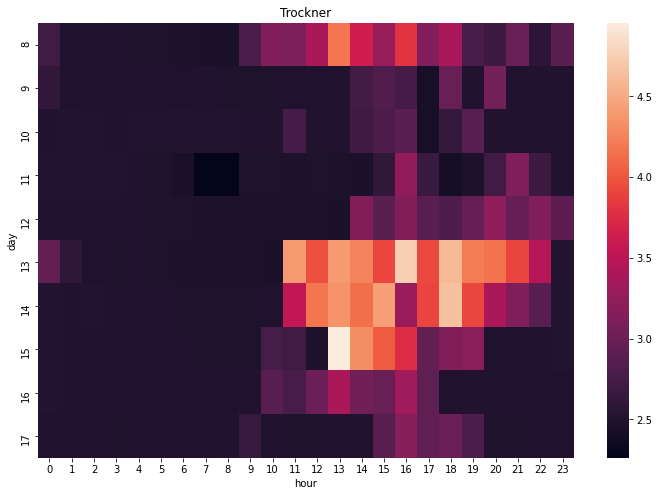

In [ ]:
pivot_heatmap(trock_1H)
plt.title('Trockner')
plt.show()

In [ ]:
pivot_heatmap(puder_1H)
plt.title('Pudermaschine')
plt.show()

In [ ]:
pivot_heatmap(vari_1H)
plt.title('Vari Air')
plt.show()

In [ ]:
pivot_heatmap(druck_1H)
plt.title('Druckmaschine')
plt.show()

In [ ]:
trock_1H

In [ ]:
trock_1H.day_name.unique()

In [ ]:
druck_1H = weekday_time_series(sensor_id='r707lv_f4032_1H')
trock_1H = weekday_time_series(sensor_id='r707lv_trockner_1H')
puder_1H = weekday_time_series(sensor_id='r707lv_f4034_1H')
vari_1H = weekday_time_series(sensor_id='r707lv_vari_air_1H')

In [ ]:
def pivot_heatmap(df):

    df_time = add_time(df)

    df_pivot = df_time.pivot(
    index='day_name',
    columns='hour',
    values='kw'
    )
    df_pivot.dropna(axis=0, how='any', inplace=True)

    #df_pivot.sort_index(axis=0, ascending=False, inplace=True)

    plt.figure(figsize=(12, 8))
    return sns.heatmap(df_pivot)

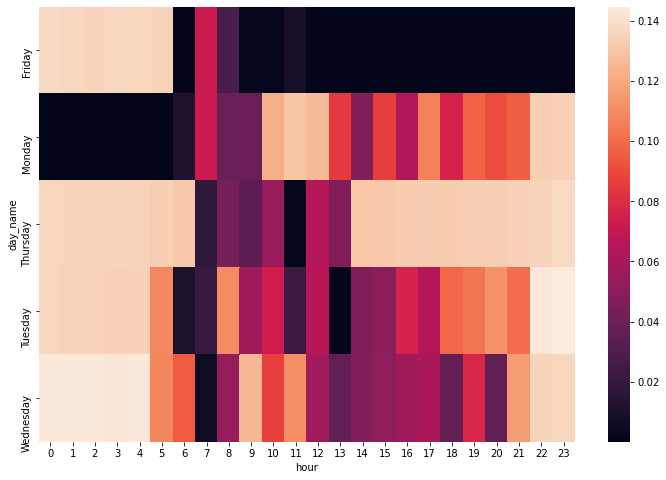

In [ ]:
pivot_heatmap(druck_1H)
plt.show()